In [36]:
!pip install -q qiskit
!pip install -q qiskit-aer
!pip install -q pylatexenc
!pip install -q qiskit_ibm_runtime

In [37]:
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer.noise import NoiseModel

In [38]:
# Define the 4 possible 2-qubit initial states using the x-gate flips needed
initial_states_config = {
    '00': [],
    '01': [0],
    '10': [1],
    '11': [0, 1]
}

In [39]:
coupling_constant = 1.0  # J = 1 for Heisenberg model
time_param = Parameter("t")
time_values = np.linspace(0, np.pi/2, 30)  # 30 evenly spaced time steps from 0 to π/2

In [40]:
# Setup simulators
ideal_backend = AerSimulator()  # Ideal, noiseless quantum simulator
fake_backend = FakeSherbrooke()  # IBM's fake device for noise modeling
noise_model = NoiseModel.from_backend(fake_backend)
noisy_backend = AerSimulator(noise_model=noise_model)

# Dictionary to store results for each initial state
all_results = {}

In [41]:
# Loop over all initial states
for initial_state_label, qubits_to_flip in initial_states_config.items():
    # Create a 2-qubit quantum circuit
    circuit = QuantumCircuit(2)

    # Apply X gate(s) to prepare desired initial state
    for qubit in qubits_to_flip:
        circuit.x(qubit)

    # Apply Heisenberg evolution gates parameterized by time
    circuit.rxx(2 * coupling_constant * time_param, 0, 1)
    circuit.ryy(2 * coupling_constant * time_param, 0, 1)
    circuit.rzz(2 * coupling_constant * time_param, 0, 1)

    circuit.measure_all()

    # Transpile
    ideal_circuit = transpile(circuit, ideal_backend)
    noisy_circuit = transpile(circuit, noisy_backend)

    # Compute the initial spin directions (Z) based on the label
    initial_z0 = 1 - 2 * int(initial_state_label[0])  # +1 for '0', -1 for '1'
    initial_z1 = 1 - 2 * int(initial_state_label[1])

    expectation_z0, expectation_z1, expectation_z0z1 = [], [], []
    correlation_z0_given_z1, correlation_z1_given_z0 = [], []
    ideal_distributions, noisy_distributions, fidelity_curve = [], [], []

    # Loop over each time value
    for time_value in time_values:
        bound_ideal_circuit = ideal_circuit.assign_parameters({time_param: time_value})

        # Simulate ideal circuit
        result_ideal = ideal_backend.run(bound_ideal_circuit, shots=1024).result()
        counts_ideal = result_ideal.get_counts()

        probs_ideal = [[state, count / 1024] for state, count in counts_ideal.items()]
        ideal_distributions.append(probs_ideal)

        # Initialize expectation values at this time step
        exp_z0, exp_z1, exp_z0z1 = 0, 0, 0
        for state, prob in probs_ideal:
            z0 = 1 - 2 * int(state[1])
            z1 = 1 - 2 * int(state[0])
            exp_z0 += prob * z0
            exp_z1 += prob * z1
            exp_z0z1 += prob * z0 * z1  # Correlated expectation

        # Save expectations
        expectation_z0.append(exp_z0)
        expectation_z1.append(exp_z1)
        expectation_z0z1.append(exp_z0z1)

        # Compute dynamical correlation functions
        correlation_z0_given_z1.append(exp_z0z1 - exp_z0 * initial_z1)
        correlation_z1_given_z0.append(exp_z0z1 - exp_z1 * initial_z0)

        # Simulate noisy version
        bound_noisy_circuit = noisy_circuit.assign_parameters({time_param: time_value})
        result_noisy = noisy_backend.run(bound_noisy_circuit, shots=1024).result()
        counts_noisy = result_noisy.get_counts()
        probs_noisy = [[state, count / 1024] for state, count in counts_noisy.items()]
        noisy_distributions.append(probs_noisy)

        # Fidelity computation between ideal and noisy distributions
        all_states = set([s for s, _ in probs_ideal] + [s for s, _ in probs_noisy])
        fidelity = 0
        for state in all_states:
            p_ideal = next((p for s, p in probs_ideal if s == state), 0)
            p_noisy = next((p for s, p in probs_noisy if s == state), 0)
            fidelity += np.sqrt(p_ideal * p_noisy)
        fidelity_curve.append(fidelity)

    # Store all computed quantities for this initial state
    all_results[initial_state_label] = {
        'expectation_z0': expectation_z0,
        'expectation_z1': expectation_z1,
        'expectation_z0z1': expectation_z0z1,
        'correlation_z0_given_z1': correlation_z0_given_z1,
        'correlation_z1_given_z0': correlation_z1_given_z0,
        'fidelity': fidelity_curve
    }

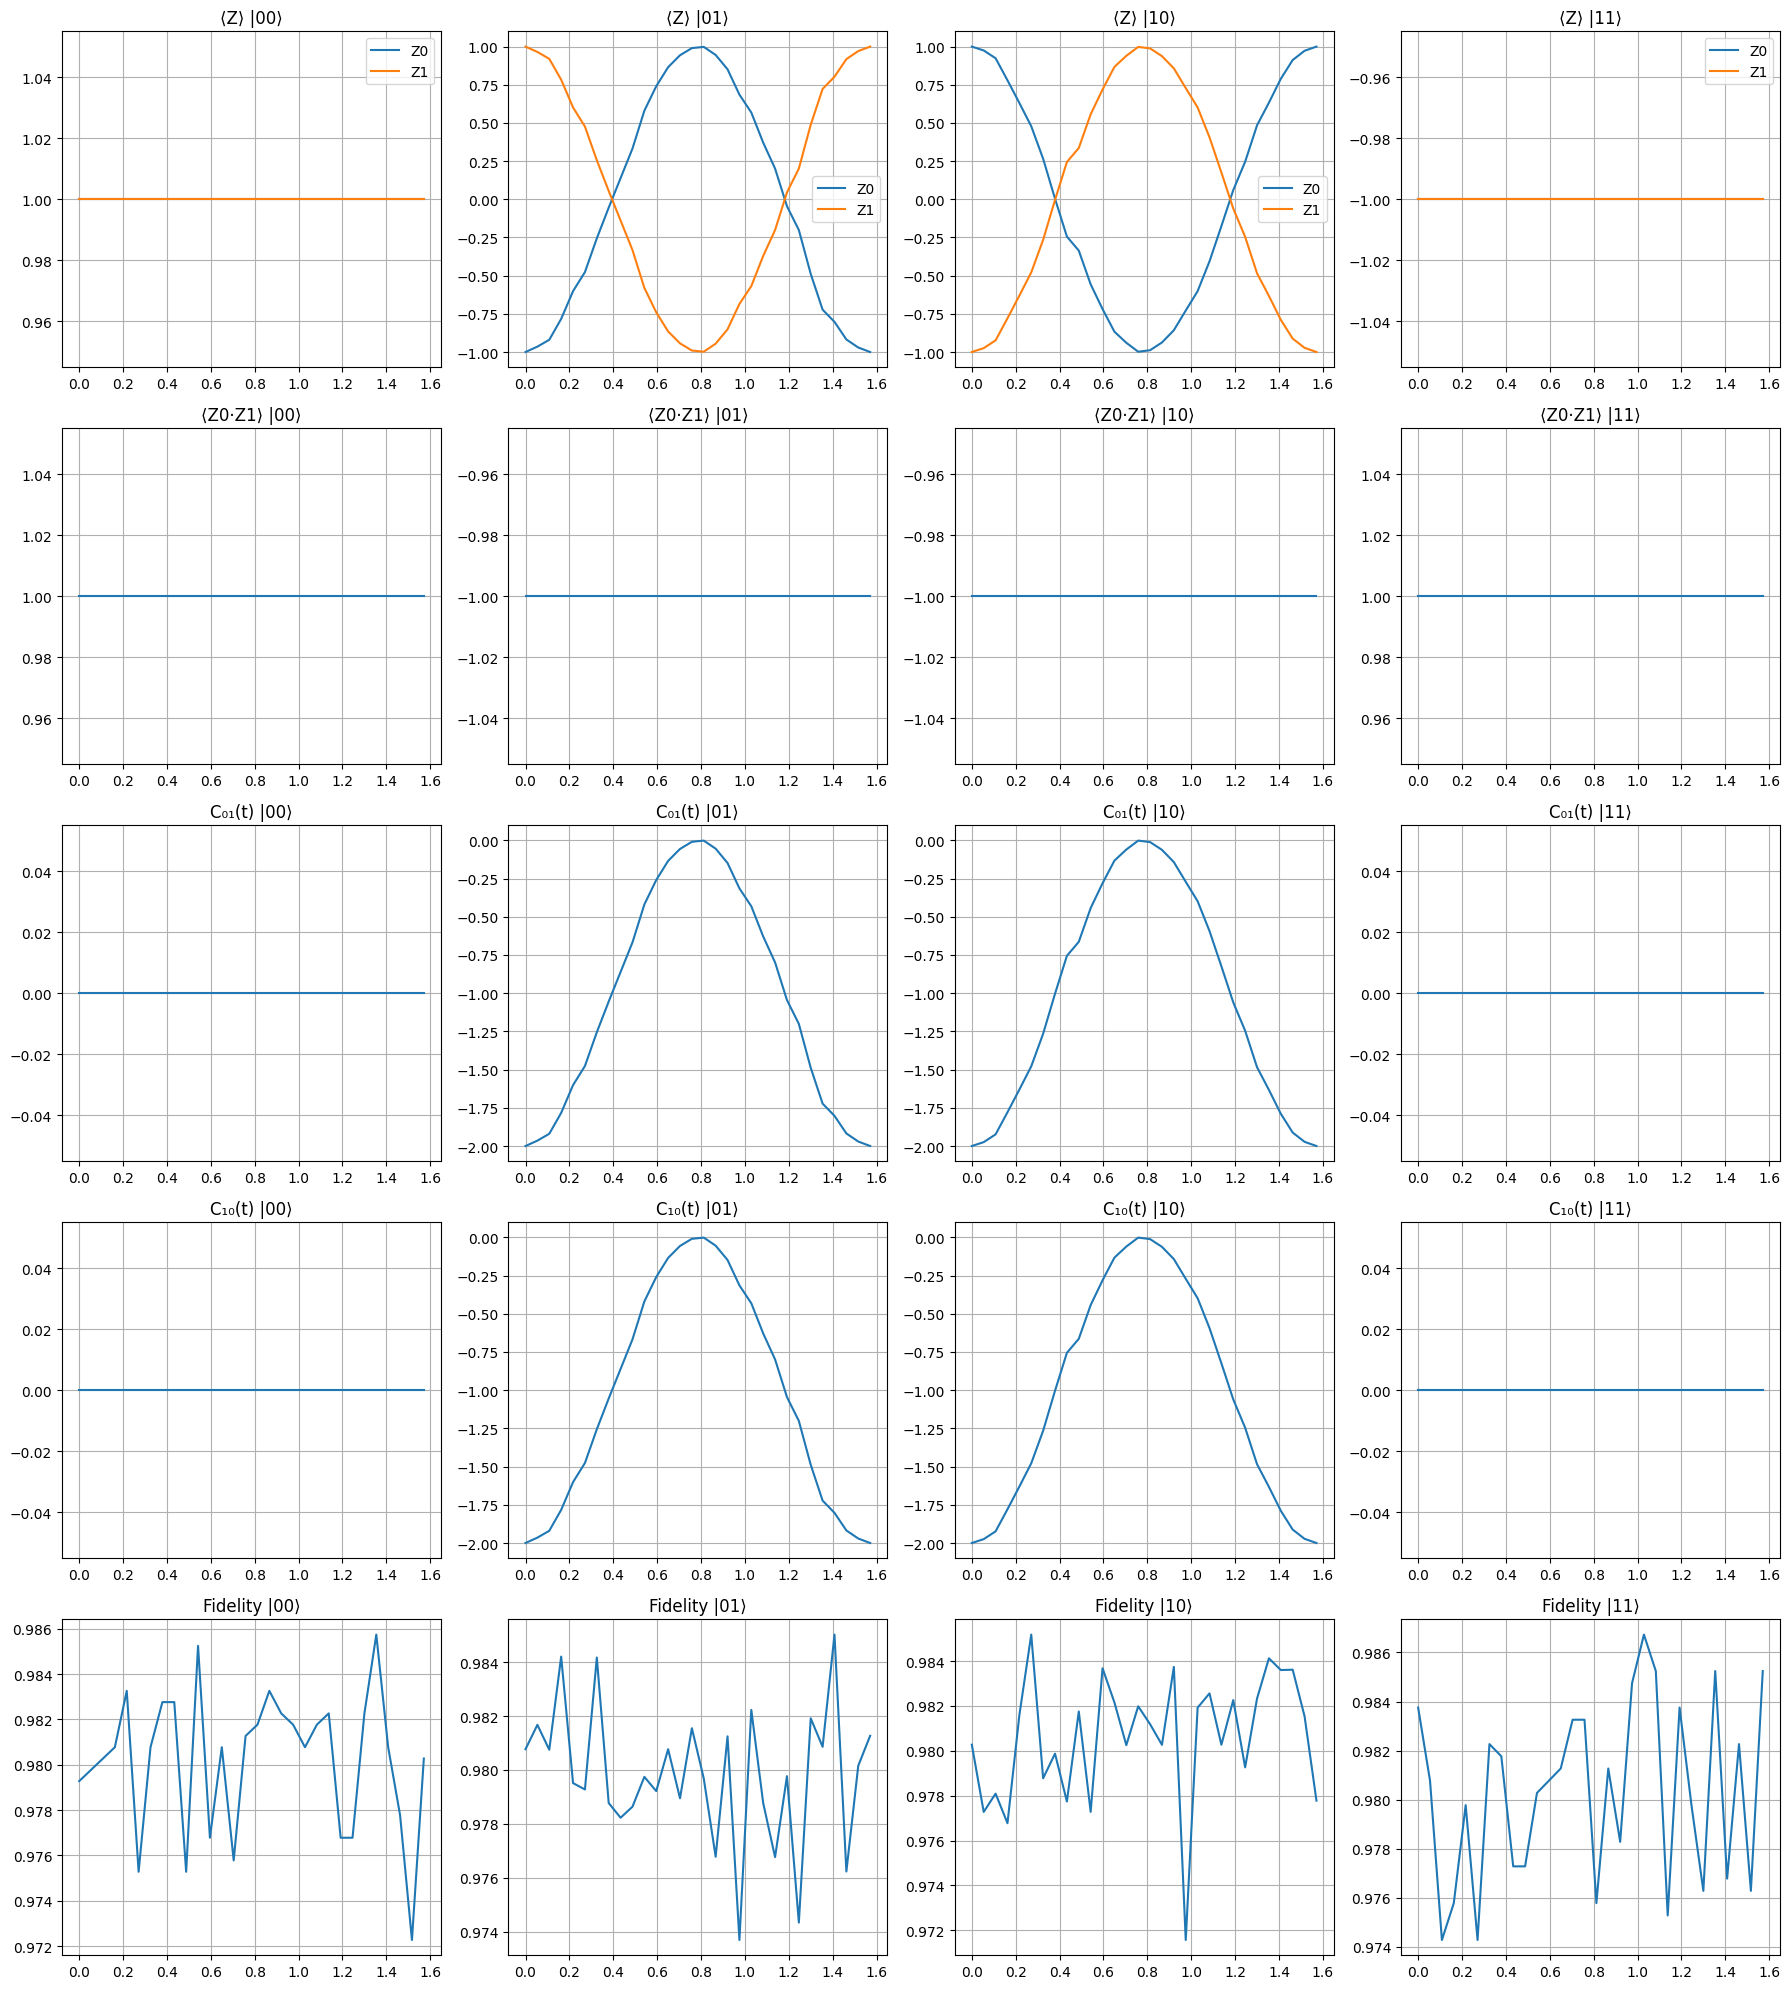

In [42]:
fig, axes = plt.subplots(5, 4, figsize=(18, 20))

# Loop over each initial state and its results
for idx, (initial_state_label, result) in enumerate(all_results.items()):
    # Expectation values of Z0 and Z1
    axes[0][idx].plot(time_values, result['expectation_z0'], label='Z0')
    axes[0][idx].plot(time_values, result['expectation_z1'], label='Z1')
    axes[0][idx].set_title(f"⟨Z⟩ |{initial_state_label}⟩")
    axes[0][idx].legend()
    axes[0][idx].grid()

    # Expectation of Z0*Z1
    axes[1][idx].plot(time_values, result['expectation_z0z1'])
    axes[1][idx].set_title(f"⟨Z0·Z1⟩ |{initial_state_label}⟩")
    axes[1][idx].grid()

    # Correlation C01(t)
    axes[2][idx].plot(time_values, result['correlation_z0_given_z1'])
    axes[2][idx].set_title(f"C₀₁(t) |{initial_state_label}⟩")
    axes[2][idx].grid()

    # Correlation C10(t)
    axes[3][idx].plot(time_values, result['correlation_z1_given_z0'])
    axes[3][idx].set_title(f"C₁₀(t) |{initial_state_label}⟩")
    axes[3][idx].grid()

    # Fidelity between noisy and ideal simulations
    axes[4][idx].plot(time_values, result['fidelity'])
    axes[4][idx].set_title(f"Fidelity |{initial_state_label}⟩")
    axes[4][idx].grid()

plt.tight_layout()
plt.show()